# Sail routing

In [2]:
import json
import datetime
import codecs
import glob

import numpy as np
import ipywidgets as widgets
from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator
from scipy.optimize import minimize, differential_evolution
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from dms2dec.dms_convert import dms2dec
from pyproj import Geod, enums
import xarray as xr

# Conversion between meters and nautical miles
NM = 1852.0

# A tiny value to prevent division by zero
EPS = 0.01

# Geodetic system
geoid = Geod(ellps="WGS84")


## Set up start point, end point and the map

In [3]:
# END POSITION: Sassnitz
END_LAT = dms2dec("""54°30'56.52" N""")
END_LON = dms2dec("""13°38'40.24" E""")
END = np.array([[END_LON], [END_LAT]])

# Starting POSITION: Rønne
STA_LAT = dms2dec("""55°06'3.28" N""")
STA_LON = dms2dec("""14°42'23.90" E""")
START = np.array([[STA_LON], [STA_LAT]])

# Compute region of map
buffer = 0.2
MIN_LON = min(STA_LON, END_LON) - buffer * abs(STA_LON - END_LON)
MIN_LAT = min(STA_LAT, END_LAT) - buffer * abs(STA_LAT - END_LAT)
MAX_LON = max(STA_LON, END_LON) + buffer * abs(STA_LON - END_LON)
MAX_LAT = max(STA_LAT, END_LAT) + buffer * abs(STA_LAT - END_LAT)

# Create map
m = Basemap(
    llcrnrlon=MIN_LON,
    llcrnrlat=MIN_LAT,
    urcrnrlon=MAX_LON,
    urcrnrlat=MAX_LAT,
    resolution="f",
    projection="merc",
)


## Wind 

In [4]:
# Read GRIB file
files = glob.glob("weather/*.grb")
for file in files:
    ds = xr.open_dataset(file, engine="cfgrib")

# Select relevant section of GRIB file
ds = ds.where(
    (ds["longitude"] > MIN_LON)
    & (ds["longitude"] < MAX_LON)
    & (ds["latitude"] > MIN_LAT)
    & (ds["latitude"] < MAX_LAT),
    drop=True,
)

# Build interpolation tables
wind_time = ds["step"].to_numpy().astype(float) / 3600.0e9
wind_lons = ds["longitude"].to_numpy()
wind_lats = ds["latitude"].to_numpy()
wind_u10 = ds["u10"].to_numpy()
wind_v10 = ds["v10"].to_numpy()
wind_u = RegularGridInterpolator(
    (wind_time, wind_lats, wind_lons), wind_u10, bounds_error=False, fill_value=0.0
)
wind_v = RegularGridInterpolator(
    (wind_time, wind_lats, wind_lons), wind_v10, bounds_error=False, fill_value=0.0
)

# Wind function
def wind(time, lon, lat):
    t = time + 6.0
    u = wind_u((t, lat, lon))
    v = wind_v((t, lat, lon))
    mag = np.sqrt(u**2 + v**2)
    dir = np.rad2deg(np.arctan(-v / (u + EPS))) - 90.0
    return [dir, mag]


## Waypoints 

In [5]:
N = 5
wp = geoid.npts(STA_LON, STA_LAT, END_LON, END_LAT, N)
waypoints = np.array([[pos[0] for pos in wp], [pos[1] for pos in wp]])
initial_waypoints = np.hstack([START, waypoints, END])

# Create initial population
POPSIZE = 15
noise = (np.random.rand(POPSIZE, len(waypoints.ravel())) - 0.5)
initial_population = np.tile(waypoints.ravel(), (POPSIZE, 1)) + noise 

## Load polar chart

In [6]:
# Load boats
boats = json.load(codecs.open("boats.json", "r", "utf-8-sig"), strict=False)
boat = list(filter(lambda b: b["boat"]["type"] == "Bavaria 38", boats))[0]

# Align measured angles and wind speeds in a meshgrid for interpolation
min_angle = max(boat["vpp"]["beat_angle"])
max_angle = 180.0
a = np.array([min_angle] + boat["vpp"]["angles"] + [max_angle], dtype=float)
s = np.array(boat["vpp"]["speeds"], dtype=float)
angles, windspeeds = np.meshgrid(a, s)

# Fill table of velocities for interpolation
vel = np.zeros_like(angles)
vel[:, 0] = boat["vpp"]["beat_vmg"]
for i, angle in enumerate(boat["vpp"]["angles"]):
    vel[:, i + 1] = boat["vpp"][f"{angle}"]
vel[:, -1] = boat["vpp"]["run_vmg"]

# Build a look up table for interpolation of boat speed
lut = RegularGridInterpolator((s, a), vel, bounds_error=False, fill_value=0.1)


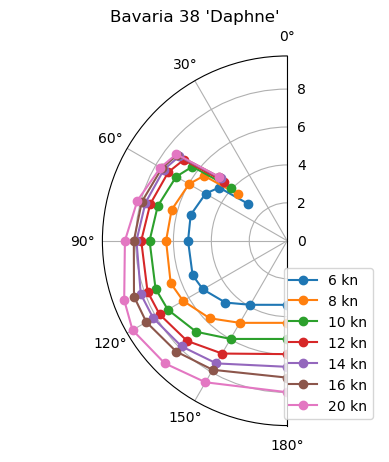

In [7]:
# Plot polar diagram of the boat
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_zero_location("N")
ax.set_thetamin(0)
ax.set_thetamax(180)
for a, v in zip(angles, vel):
    ax.plot(np.deg2rad(a), v, "o-")
plt.legend([f"{ws} kn" for ws in boat["vpp"]["speeds"]], loc="lower right")
plt.title(boat["boat"]["type"] + " '" + boat["name"] + "'")
plt.show()

In [8]:
def velocity(course, wind_dir, wind_mag):
    angle = np.abs(((course + 360.0) % 360.0 - wind_dir))
    if angle > 180:
        angle = 360.0 - angle
    return lut((wind_mag, angle))


## Compute travel time 

In [9]:
def compute_path(waypoints, opt=False):
    wpts = np.hstack([START, waypoints.reshape(2, -1), END])
    lons = wpts[0, :]
    lats = wpts[1, :]
    int_time = 0
    if not opt:
        t = []
        v = []
        la = []
        lo = []
    lengths = geoid.line_lengths(lons, lats)
    for i in range(1, len(lons)):
        del_s = min(500, lengths[i - 1] / 2.0)
        flags = enums.GeodIntermediateFlag.AZIS_KEEP
        intp = geoid.inv_intermediate(
            lons[i - 1],
            lats[i - 1],
            lons[i],
            lats[i],
            del_s=del_s,
            terminus_idx=0,
            flags=flags,
        )
        ds = intp.del_s / NM
        for lon, lat, azi in zip(intp.lons, intp.lats, intp.azis):
            wind_dir, wind_mag = wind(int_time, lon, lat)
            vel = velocity(azi, wind_dir, wind_mag)
            int_time += ds / vel
            if not opt:
                t.append(int_time)
                v.append(vel)
                la.append(lat)
                lo.append(lon)
    if opt:
        return int_time
    else:
        return {
            "time": np.array(t),
            "velocity": np.array(v),
            "lons": np.array(lo),
            "lats": np.array(la),
        }


# import cProfile
# import pstats
# cProfile.run('compute_path(waypoints, start, end)', 'stats')
# p = pstats.Stats('stats')
# p.sort_stats(pstats.SortKey.TIME).print_stats(10)


In [10]:
def callback(waypoints, convergence):
    wpts = np.hstack([START, waypoints.reshape(2, -1), END])
    m.drawcoastlines()
    m.fillcontinents()
    m.drawgreatcircle(
        STA_LON, STA_LAT, END_LON, END_LAT, del_s=1, color="k", linestyle=":"
    )
    # Plot waypoints
    x, y = m(wpts[0, :], wpts[1, :])
    m.plot(x, y, color="k", marker="X")
    plt.show()


## Optimization

In [11]:
bounds = N * [(MIN_LON, MAX_LON)] + N * [(MIN_LAT, MAX_LAT)]
opt = differential_evolution(
    compute_path,
    bounds,
    args=(True,),
    disp=True,
    maxiter=100,
    init=initial_population,
    # callback=callback,
)
waypoints = opt.x.reshape(2, -1)

path = compute_path(waypoints)
full_waypoints = np.hstack([START, waypoints, END])
dist = geoid.line_length(full_waypoints[0, :], full_waypoints[1, :]) / NM

# Print resulting calculation
td = datetime.timedelta(hours=path["time"][-1])
td = ":".join(str(td).split(":")[:2])
print(f"The travel time is {td} h for {dist:.2f} nautical miles.")


differential_evolution step 1: f(x)= 26.5296
differential_evolution step 2: f(x)= 26.5296
differential_evolution step 3: f(x)= 26.5296
differential_evolution step 4: f(x)= 26.5296
differential_evolution step 5: f(x)= 15.6689
differential_evolution step 6: f(x)= 15.6689
differential_evolution step 7: f(x)= 12.7169
differential_evolution step 8: f(x)= 12.7169
differential_evolution step 9: f(x)= 12.7169
differential_evolution step 10: f(x)= 12.7169
differential_evolution step 11: f(x)= 11.6295
differential_evolution step 12: f(x)= 11.6295
differential_evolution step 13: f(x)= 11.6295
differential_evolution step 14: f(x)= 11.6295
differential_evolution step 15: f(x)= 11.6295
differential_evolution step 16: f(x)= 11.6295
differential_evolution step 17: f(x)= 11.6295
differential_evolution step 18: f(x)= 11.6295
differential_evolution step 19: f(x)= 11.6295
differential_evolution step 20: f(x)= 11.6295
differential_evolution step 21: f(x)= 11.6295
differential_evolution step 22: f(x)= 11.58

## Plot path

In [44]:
def plot_func(time):
    # Clear plot
    plt.clf()

    # Draw map
    m.drawcoastlines()
    m.fillcontinents()
    m.drawgreatcircle(
        STA_LON,
        STA_LAT,
        END_LON,
        END_LAT,
        del_s=1,
        color="k",
        linestyle=":",
    )

    # Print wind magnitude
    wlons, wlats = np.meshgrid(wind_lons, wind_lats)
    xx, yy = m(wlons, wlats)
    wdir, wmag = wind(time, wlons, wlats)
    cont = m.contourf(xx, yy, wmag, cmap="magma", alpha=0.5)
    plt.colorbar(cont, label="Windspeed in kn")

    # Plot wind barbs
    all_lons = np.linspace(MIN_LON, MAX_LON, 8)
    all_lats = np.linspace(MIN_LAT, MAX_LAT, 8)
    alons, alats = np.meshgrid(all_lons, all_lats)
    xx, yy = m(alons, alats)
    wdir, wmag = wind(time, alons, alats)
    vx = -wmag * np.sin(np.deg2rad(wdir))
    vy = -wmag * np.cos(np.deg2rad(wdir))
    m.barbs(xx, yy, vx, vy)

    # Plot path
    idx = np.where(path["time"] < time)
    x, y = m(path["lons"][idx], path["lats"][idx])
    velocity = path["velocity"][idx]
    vmin = np.min(path["velocity"])
    vmax = np.max(path["velocity"])
    scat = m.scatter(x, y, c=velocity, vmin=vmin, vmax=vmax)
    plt.colorbar(scat, label="Boatspeed in kn")

    # Plot waypoints
    x, y = m(full_waypoints[0, :], full_waypoints[1, :])
    m.scatter(x, y, color="k", marker="X")

    # Draw plot
    plt.draw()

widgets.interact(
    plot_func,
    time=widgets.FloatSlider(
        value=path["time"][-1], min=0.1, max=path["time"][-1], step=0.1
    ),
)


interactive(children=(FloatSlider(value=9.68019866952317, description='time', max=9.68019866952317, min=0.1), …

<function __main__.plot_func(time)>

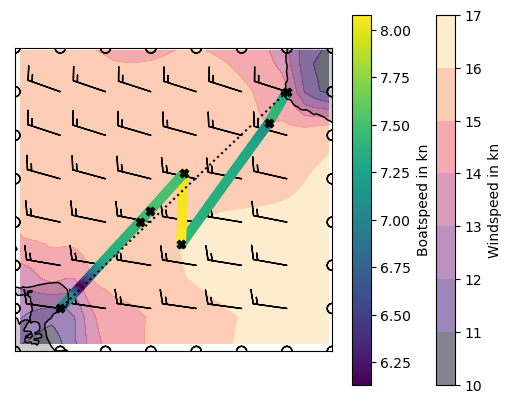

In [45]:
fig = plt.figure()
anim = animation.FuncAnimation(fig, func=plot_func,frames=np.linspace(0, path["time"][-1], 60))
anim.save("animation.mp4", writer=animation.FFMpegWriter(fps=30))